# Kitty Facial Recognition
<img src="mischa_example_box.png" width="250" style="float: left; padding-right:20px;padding-top:10px">
##### Executive Summary
The goal of this weekend project was to attempt to develop a facial recongition model for my cat, Mischa (see left). To achieve this, I had to learn about "deep learning", which I didn't have any prior knowledge of. Additionally, I had to collect data, so I took over 250 pictures of Mischa and collected 250 images of random cats on the internet. These images were used to train a model using the convolutional neural network algorithm, the best deep learning method for image analysis (so the internet says).

Two different approaches were tried: (1) created a model from scratch and (2) customized a pre-existing model. The results show model #1 was 44% - 56% accurate, while model #2 was 50 - 66% accurate. Since a random guess would be 50% accurate in this case, customizing a pre-existing model is the best solution and performs slightly better than guessing.

To improve the model in future iterations I would: (1) learn more about deep learning, (2) gather more pictures of Mischa and random cats, and (3) use a machine with GPU to increase computational power.

<br>

##### Method
This Jupyter notebook contains the following sections:
1. Prepare Data
2. Develop Model
3. Analyze Results

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras import models, applications

## Example: Mischa vs. Not Mischa

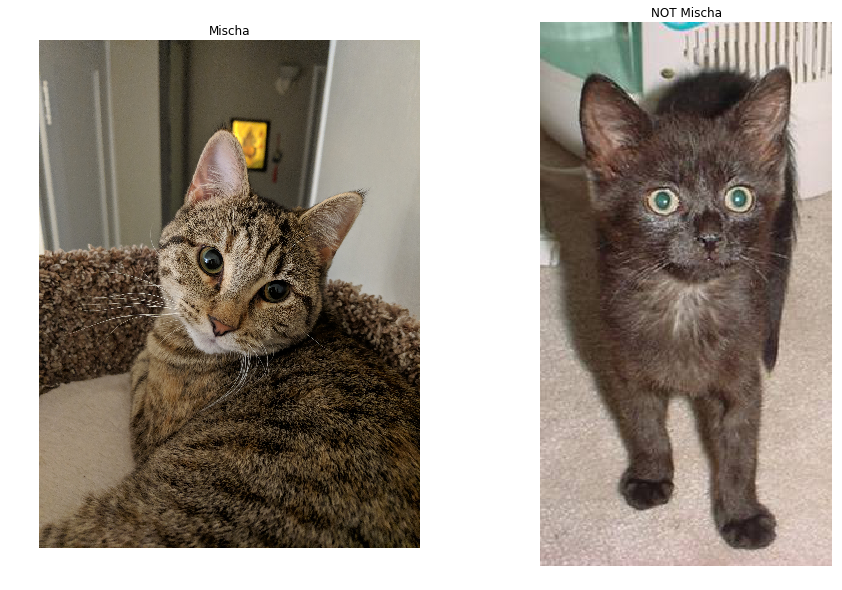

In [2]:
# Read example images and display
plt.subplots(2,2,figsize=(15,10), sharey=True)

plt.subplot(1,2,1)
plt.title('Mischa')
mischa = plt.imread("mischa_example.jpg")
plt.axis('off')
plt.imshow(mischa)

plt.subplot(1,2,2)
plt.title('NOT Mischa')
notmischa = plt.imread("notmischa_example.jpg")
plt.axis('off')
plt.imshow(notmischa)

plt.show()

## 1. Prepare Data

Converting 250 Mischa pictures and 250 random cat pictures into data to train & test the model. 200 pictures will be used for training the model and the remaining 50 will be used to test the accuracy of the model.

In [49]:
# Set pixel size of images
img_width, img_height = 500, 500
input_shape = (img_width, img_height, 3)

# Set other model variables
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data_mischa_recognition/train'
validation_data_dir = 'data_mischa_recognition/test'
nb_train_samples = 200
nb_validation_samples = 50
epochs = 10 
batch_size = 10

In [50]:
# Generate tensor data from training and testing images
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Class: Mischa
Image Data: (500, 500, 3)


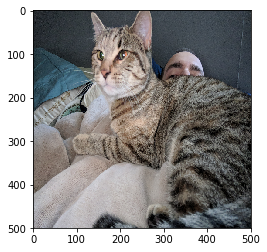

In [56]:
# Generate an example image
data = train_generator.next()

# Print image data
if data[1][0] == 0.0: 
    print("Class: Mischa")
else: 
    print("Class: Not Mischa")
print("Image Data: " + str(data[0][0].shape))

# Show image
data_example = data[0][0]
plt.imshow((data_example).astype(np.uint8))
plt.show()

## 2. Develop Model

### Homemade Model
Creating a simple CNN deep learning model.

In [57]:
# Create model
# First convolutional Layer
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPool2D(2))

# Second convolutional Layer
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

# Third convolutional Layer
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

# Connecting Layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

In [58]:
# Compile and fit model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

results = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples // batch_size,
                              callbacks=[checkpointer],
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples // batch_size)

model.load_weights('best_weights.hdf5')
model.save('shapes_cnn.h5')

Epoch 1/10
20/20 [==============================] - 124s 6s/step - loss: 7.6603 - acc: 0.5100 - val_loss: 9.0261 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to best_weights.hdf5
Epoch 2/10
20/20 [==============================] - 103s 5s/step - loss: 8.1388 - acc: 0.4950 - val_loss: 7.0920 - val_acc: 0.5600

Epoch 00002: val_acc improved from 0.44000 to 0.56000, saving model to best_weights.hdf5
Epoch 3/10
20/20 [==============================] - 105s 5s/step - loss: 8.3008 - acc: 0.4850 - val_loss: 8.3814 - val_acc: 0.4800

Epoch 00003: val_acc did not improve from 0.56000
Epoch 4/10
20/20 [==============================] - 106s 5s/step - loss: 7.8979 - acc: 0.5050 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00004: val_acc did not improve from 0.56000
Epoch 5/10
20/20 [==============================] - 106s 5s/step - loss: 7.8173 - acc: 0.5150 - val_loss: 8.3814 - val_acc: 0.4800

Epoch 00005: val_acc did not improve from 0.56000
Epoch 6/10
20/2

### Existing Model Adjusted
As known as "Transfer Learning". In this case, leveraging a pre-built model (VGG16) trained on the ImageNet dataset.

In [44]:
# Run training and validation data through model and save output
datagen = ImageDataGenerator()

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [47]:
# Use output of VGG16 model re-trained on our data to input into a new fully connected model
train_data = np.load(open('bottleneck_features_train.npy','rb'))
train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
validation_labels = np.array([0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

results = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

model.save_weights('bottleneck_fc_model.h5')

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 23s 113ms/step - loss: 6.9366 - acc: 0.5450 - val_loss: 7.0332 - val_acc: 0.5400
Epoch 2/10
200/200 [==============================] - 20s 100ms/step - loss: 6.1535 - acc: 0.6150 - val_loss: 6.7485 - val_acc: 0.5800
Epoch 3/10
200/200 [==============================] - 20s 101ms/step - loss: 6.6076 - acc: 0.5750 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/10
200/200 [==============================] - 20s 99ms/step - loss: 6.6253 - acc: 0.5800 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/10
200/200 [==============================] - 20s 102ms/step - loss: 5.8586 - acc: 0.6250 - val_loss: 5.7394 - val_acc: 0.6400
Epoch 6/10
200/200 [==============================] - 20s 102ms/step - loss: 6.1463 - acc: 0.6150 - val_loss: 7.0953 - val_acc: 0.5400
Epoch 7/10
200/200 [==============================] - 21s 106ms/step - loss: 5.8183 - acc: 0.6350 - val_loss: 7.3335 - val_acc: 0.5400
Epoch 8/10


## 3. Analyze Results

### Model Accuracy
Accuracy of guessing whether or not the picture is of Mischa. 50% is a random guess. Results are shown for 6 different models.

#### Homemade Model

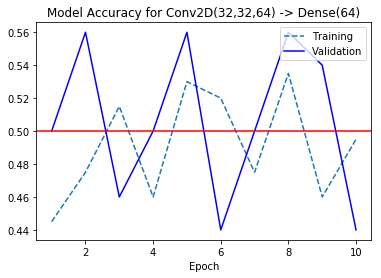

In [81]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Conv2D(32,32,64) -> Dense(64)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

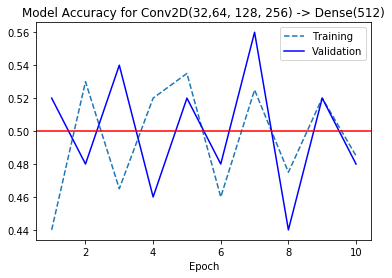

In [108]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Conv2D(32,64, 128, 256) -> Dense(512)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

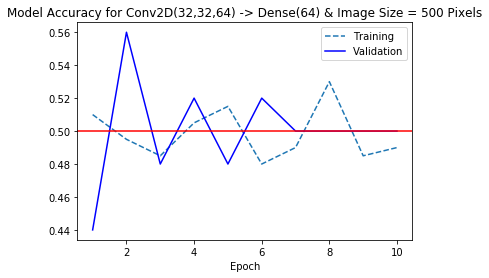

In [59]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Conv2D(32,32,64) -> Dense(64) & Image Size = 500 Pixels')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Existing Model Adjusted

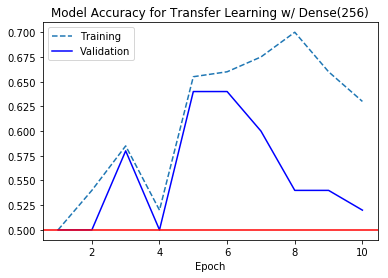

In [28]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Transfer Learning w/ Dense(256) & Dropout = 50%')
plt.xlabel('Epoch')
plt.legend()
plt.show()

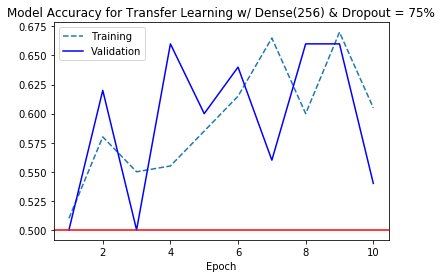

In [37]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Transfer Learning w/ Dense(256) & Dropout = 75%')
plt.xlabel('Epoch')
plt.legend()
plt.show()

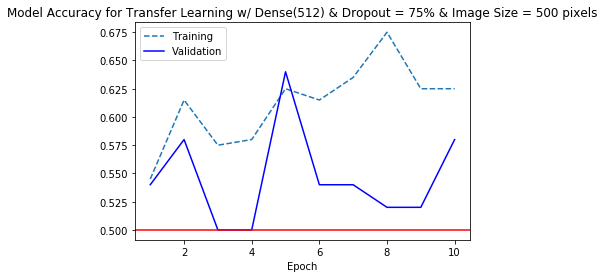

In [48]:
acc = results.history['acc']
val_acc = results.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '--', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.axhline(y=.5, color='red')
plt.title('Model Accuracy for Transfer Learning w/ Dense(512) & Dropout = 75% & Image Size = 500 pixels')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---
#### Sources
- Datacamp - Deep Learning in Python: https://www.datacamp.com/courses/deep-learning-in-python
- Datacamp - CNN for Images:https://www.datacamp.com/courses/convolutional-neural-networks-for-image-processing
- Keras Blog - Image Classification: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html